## Data Analysis

### Import Modules

In [1]:
#Data Cleaning
import pandas as pd
import numpy as np
from scipy.stats import linregress

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sn

# Data Extraction
import requests
import json

### Load Data from CSV

In [2]:
iso_cleaned_df = pd.read_csv('./Resources/isoDataFinal.csv')

In [3]:
iso_cleaned_df.head(10)

,iso_code,total_vaccinations,people_fully_vaccinated_per_hundred,GDP,Total_Pop,Pop_Den,health_exp
0,ALB,400064.0,0.02,1.514702e+10,2866376.0,104.612263,44.657787
1,AND,26414.0,6.06,3.218316e+09,77006.0,163.842553,32.065220
2,ARE,10336214.0,38.79,4.222150e+11,9630959.0,135.609110,48.421539
3,ARG,7386650.0,1.95,5.176267e+11,44494502.0,16.258510,38.290127
4,AUT,2863389.0,8.73,4.550949e+11,8840521.0,107.131859,26.914829
5,AZE,1440243.0,4.87,4.711294e+10,9939771.0,120.257592,72.804810
6,BEL,3563371.0,6.60,5.437344e+11,11427054.0,377.379590,24.215460
7,BGD,7954176.0,1.31,2.740391e+11,161356039.0,1239.579312,76.501839
8,BGR,750899.0,2.56,6.623016e+10,7025037.0,64.711100,42.363476
9,BHR,1206763.0,31.14,3.765250e+10,1569439.0,2012.101282,41.167648


### Split Data by GDP quartiles

In [4]:
# Cut data into GDP quartiles
iso_cleaned_df['Bins'] = pd.qcut(iso_cleaned_df['GDP'],4,labels=['Q1','Q2','Q3','Q4'])

<AxesSubplot:xlabel='Bins'>

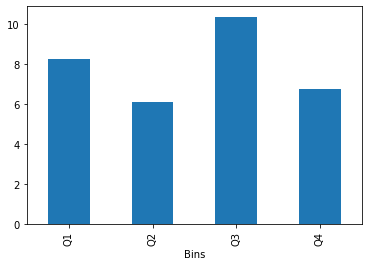

In [5]:
# Group data by bins and look at mean vaccination
iso_cleaned_df.groupby('Bins')['people_fully_vaccinated_per_hundred'].mean().plot(kind='bar')

In [ ]:
#more analysis needed
#Break down into each quartile and run the linear regression below

### Linear Regression for total vaccination percentage

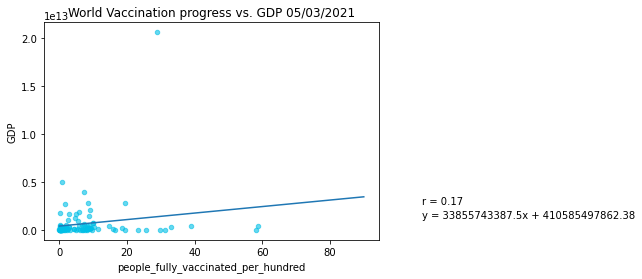

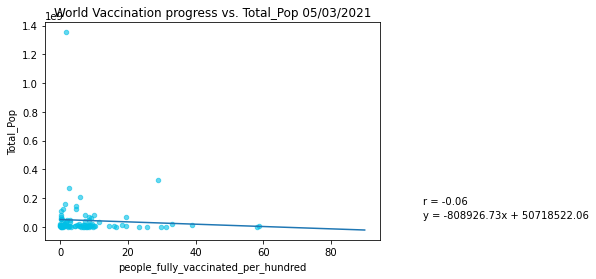

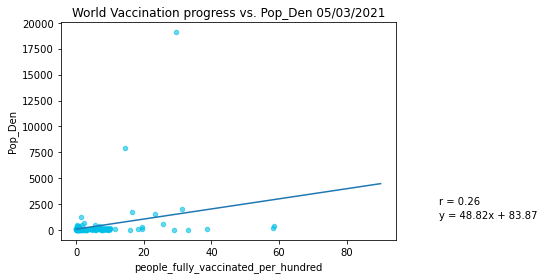

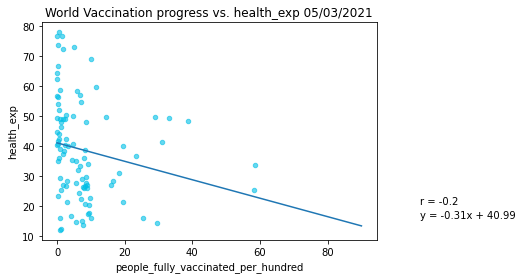

In [6]:
# Linear Regression for each data series compared to Vaccinations per 100 people
y_values = ['GDP','Total_Pop','Pop_Den','health_exp']
for metric in y_values:
    #
    x1 = iso_cleaned_df['people_fully_vaccinated_per_hundred']
    y1 = iso_cleaned_df[metric]
    analysisDate = '05/03/2021'
    
    #lin reg line
    slope, intercept, rvalue, pvalue, stderr = linregress(x1,y1)
    z = range(0,100,10)
    w = slope * z + intercept
    
    #Scatter plot and lin reg line
    fig, ax = plt.subplots()
    scatter = ax.scatter(x1, y1, s=20,color=(0,.75,.9),alpha=.6)
    
    plt.plot(z,w)
    plt.text(1,.25,f'r = {round(rvalue,2)}', transform=plt.gcf().transFigure)
    plt.text(1,.20,f'y = {round(slope,2)}x + {round(intercept,2)}', transform=plt.gcf().transFigure)
    
    #Formatting
    plt.title('World Vaccination progress vs. '+y1.name + ' '+ analysisDate)
    plt.xlabel(x1.name)
    plt.ylabel(y1.name)
    
    #Save figure and display
    plt.savefig(f'./Resources/Output/{x1.name}.{y1.name}Line.png')
    plt.show()

### Best and Worst performing countries in vaccine deployment

In [7]:
# Best performing countries
# Use the initial dataset for this analysis since it doesnt require any indicators
x = iso_cleaned_df[['iso_code','people_fully_vaccinated_per_hundred']]
x.sort_values(by='people_fully_vaccinated_per_hundred',ascending=False).head(5)

,iso_code,people_fully_vaccinated_per_hundred
45,ISR,58.63
88,SYC,58.21
2,ARE,38.79
15,CHL,33.11
9,BHR,31.14


In [8]:
# Worst performing Contries
x.sort_values(by='people_fully_vaccinated_per_hundred').head(5)

,iso_code,people_fully_vaccinated_per_hundred
35,GTM,0.01
0,ALB,0.02
67,NAM,0.03
37,HND,0.03
81,SLE,0.07
